In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchtext
import torchtext.transforms as T
from torch.utils.data import DataLoader
from torchlake.common.schemas.nlp import NlpContext
from torchlake.common.utils.platform import get_num_workers
from torchlake.common.utils.text import (build_vocab, get_context,
                                         get_unigram_counts, is_corpus_title,
                                         is_longer_text)
from torchtext.data.utils import get_tokenizer
from torchlake.common.utils.platform import get_file_size
from torchlake.language_model.models.ppmi.helper import CoOccurrenceCounter
from torchlake.language_model.models import PPMI
from torchtext.datasets import WikiText2, WikiText103

To utilize this notebook, you have to install `portalocker` first

In [2]:
torch.__version__

'2.1.0+cu118'

In [3]:
torchtext.__version__

'0.16.0+cpu'

# setting


In [4]:
DATASET_NAME = "WikiText2"

In [5]:
artifact_path = Path('../../artifacts/ppmi')
artifact_dataset_path = artifact_path / DATASET_NAME
data_path = Path('../../data') / DATASET_NAME

In [6]:
CONTEXT = NlpContext(device="cpu")

In [7]:
BATCH_SIZE = 32
CONTEXT_SIZE = 5

In [8]:
DEVICE = torch.device(CONTEXT.device)

In [9]:
tokenizer = get_tokenizer('basic_english')

In [10]:
def datapipe_factory(datapipe, context_size: int = 1, transform = None):
    datapipe = (
        datapipe
        .map(lambda text: text.strip())
        .map(lambda text: text.lower())
        .filter(lambda text: is_longer_text(text, context_size))
        .filter(lambda text: not is_corpus_title(text))
        .map(tokenizer)
    )

    if transform:
      datapipe = datapipe.map(transform)

    return datapipe

In [11]:
train_datapipe, val_datapipe, test_datapipe = WikiText2(data_path.as_posix())

In [12]:
cloned_train_datapipe = datapipe_factory(train_datapipe, CONTEXT_SIZE)
vocab = build_vocab(cloned_train_datapipe)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [13]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

20351

In [14]:
# write_json_file(
#     artifact_dataset_path.joinpath("vocab.json"),
#     list(vocab.get_stoi().keys()),
# )

In [15]:
vocab.lookup_tokens(range(20))

['<unk>',
 '<bos>',
 '<eos>',
 '<pad>',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 'to',
 'a',
 'was',
 "'",
 '@-@',
 'on',
 'as',
 's',
 'that',
 'for']

In [16]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [17]:
train_datapipe = datapipe_factory(
    train_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

val_datapipe = datapipe_factory(
    val_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [18]:
NUM_WORKERS = get_num_workers()

In [19]:
collate_fn = lambda data: get_context(
    data,
    CONTEXT_SIZE // 2,
    CONTEXT_SIZE // 2,
    enable_random_context_size=False, # you can enable random context size for skipgram
    flatten_output=True,
)

train_dataloader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

val_dataloader = DataLoader(
    val_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

In [20]:
# check context size
# for data in train_datapipe:
#     if len(data) < 5:
#         print(data)
#         break

In [21]:
# sample
# for data in train_datapipe:
#     if len(data) > 5:
#         print(data)
#         print(vocab.lookup_tokens(data))
#         break

In [22]:
# count = 0
# for data in train_datapipe:
#   count += len(data)
# count

In [23]:
# number of words in training corpurs
# wikitext2 count 1,993,228
# wikitext103 count 101,227,641

In [24]:
for gram, context in train_dataloader:
    print(gram.shape, context.shape)
    break

torch.Size([8064, 1]) torch.Size([8064, 4])


# training


In [25]:
word_counts = get_unigram_counts(
    map(lambda x: x.tolist(), train_datapipe),
    VOCAB_SIZE,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [26]:
sum(word_counts)

tensor(4468736)

In [27]:
counter = CoOccurrenceCounter()

# 4 mins for wikitext103
# 4 mins for unigram counts
# 26 mins for co-occcurrence (more than 4 times)
for gram, context in train_dataloader:
    counter.update_counts(gram, context)

In [28]:
for (g, c), count in counter.counts.items():
    if count > 1:
        print(g, c, count)
        break

3867 (19939, 85, 89, 0) 4


In [29]:
model = PPMI(VOCAB_SIZE, CONTEXT_SIZE)

In [30]:
model.fit(counter, word_counts)

100%|██████████| 1846743/1846743 [01:30<00:00, 20361.79it/s]


In [31]:
model.embedding.shape

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\language_model\models\ppmi\model.py:31: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ..\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  ).to_sparse_csr(),


torch.Size([20351, 81404])

In [32]:
model.transform(next(iter(train_datapipe)))

tensor(indices=tensor([[     1,      1,      1,  ...,    255,    255,    255],
                       [  2237,   3059,   3449,  ..., 325476, 325550, 325560]]),
       values=tensor([19.7695, 19.7695, 19.7695,  ...,  5.7911,  5.7911,
                       5.7911]),
       size=(256, 81404), nnz=3390166, layout=torch.sparse_coo)

# Visualization

In [33]:
encoded_dims = [row._nnz() for row in model.embedding]

(0.0, 1000.0)

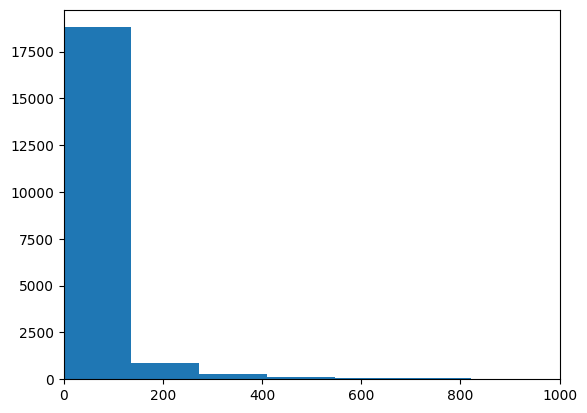

In [54]:
plt.hist(encoded_dims, bins=3000)
plt.xlim(0, 1000)

In [35]:
import numpy as np

In [36]:
encoded_dims = np.array(encoded_dims)

print("mean dim:", encoded_dims.mean())
print("median dim:", np.median(encoded_dims))
print("max dim:", encoded_dims.max())
print("min dim:", encoded_dims[encoded_dims != 0].min())
print("# of zero dim:", sum(encoded_dims == 0)) # about 3rd of vocab is not center word or too small PPMI

mean dim: 85.80330204903936
median dim: 13.0
max dim: 410672
min dim: 1
# of zero dim: 6294


# Save & Load

In [40]:
model_path = artifact_path / f"ppmi.{DATASET_NAME}.pth"

In [41]:
import joblib

In [42]:
joblib.dump(model, model_path)

['..\\..\\artifacts\\ppmi\\ppmi.WikiText2.pth']

In [43]:
get_file_size(model_path)

'64.11MB'

In [44]:
model = joblib.load(model_path)

# Evaluation


## word analogy


In [45]:
from torchlake.language_model.datasets import WordAnalogyDataset 

In [46]:
analogy_data_path = Path('../../data') / "word-analogy"

In [47]:
dataset = WordAnalogyDataset(analogy_data_path)

In [48]:
dataset.data[:20]

[('Athens', 'Greece', 'Baghdad', 'Iraq'),
 ('Athens', 'Greece', 'Bangkok', 'Thailand'),
 ('Athens', 'Greece', 'Beijing', 'China'),
 ('Athens', 'Greece', 'Berlin', 'Germany'),
 ('Athens', 'Greece', 'Bern', 'Switzerland'),
 ('Athens', 'Greece', 'Cairo', 'Egypt'),
 ('Athens', 'Greece', 'Canberra', 'Australia'),
 ('Athens', 'Greece', 'Hanoi', 'Vietnam'),
 ('Athens', 'Greece', 'Havana', 'Cuba'),
 ('Athens', 'Greece', 'Helsinki', 'Finland'),
 ('Athens', 'Greece', 'Islamabad', 'Pakistan'),
 ('Athens', 'Greece', 'Kabul', 'Afghanistan'),
 ('Athens', 'Greece', 'London', 'England'),
 ('Athens', 'Greece', 'Madrid', 'Spain'),
 ('Athens', 'Greece', 'Moscow', 'Russia'),
 ('Athens', 'Greece', 'Oslo', 'Norway'),
 ('Athens', 'Greece', 'Ottawa', 'Canada'),
 ('Athens', 'Greece', 'Paris', 'France'),
 ('Athens', 'Greece', 'Rome', 'Italy'),
 ('Athens', 'Greece', 'Stockholm', 'Sweden')]

In [49]:
tokens = [tuple(vocab[word.lower()] for word in pairs) for pairs in dataset.data]
tokens[:10]

[(12958, 6970, 18304, 5313),
 (12958, 6970, 9016, 6480),
 (12958, 6970, 10275, 1346),
 (12958, 6970, 4686, 1270),
 (12958, 6970, 0, 4409),
 (12958, 6970, 14016, 2280),
 (12958, 6970, 16617, 481),
 (12958, 6970, 14322, 1572),
 (12958, 6970, 17076, 6546),
 (12958, 6970, 0, 6575)]

In [50]:
vectors = [model.transform(row) for row in tokens]

In [51]:
for country_a, capital_a, country_b, capital_b in vectors[:30]:
    vec_a, vec_b = country_a - capital_a, country_b - capital_b
    dot_product = sum(vec_a * vec_b)
    dot_product = dot_product / vec_a.square().sum().sqrt() / vec_b.square().sum().sqrt()
    print(dot_product.item())

0.0
0.0
0.0
0.0
0.0016491588903591037
0.0
0.0
0.0
0.0
-0.0008748442633077502
-0.0008852179744280875
-0.0008794434834271669
0.0
0.0
0.0
0.0
0.006095084827393293
0.004382655955851078
0.0
0.0
-0.0008820186485536397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
